In [1]:
import numpy as np
import pandas as pd

# **EDA for numerical values:**

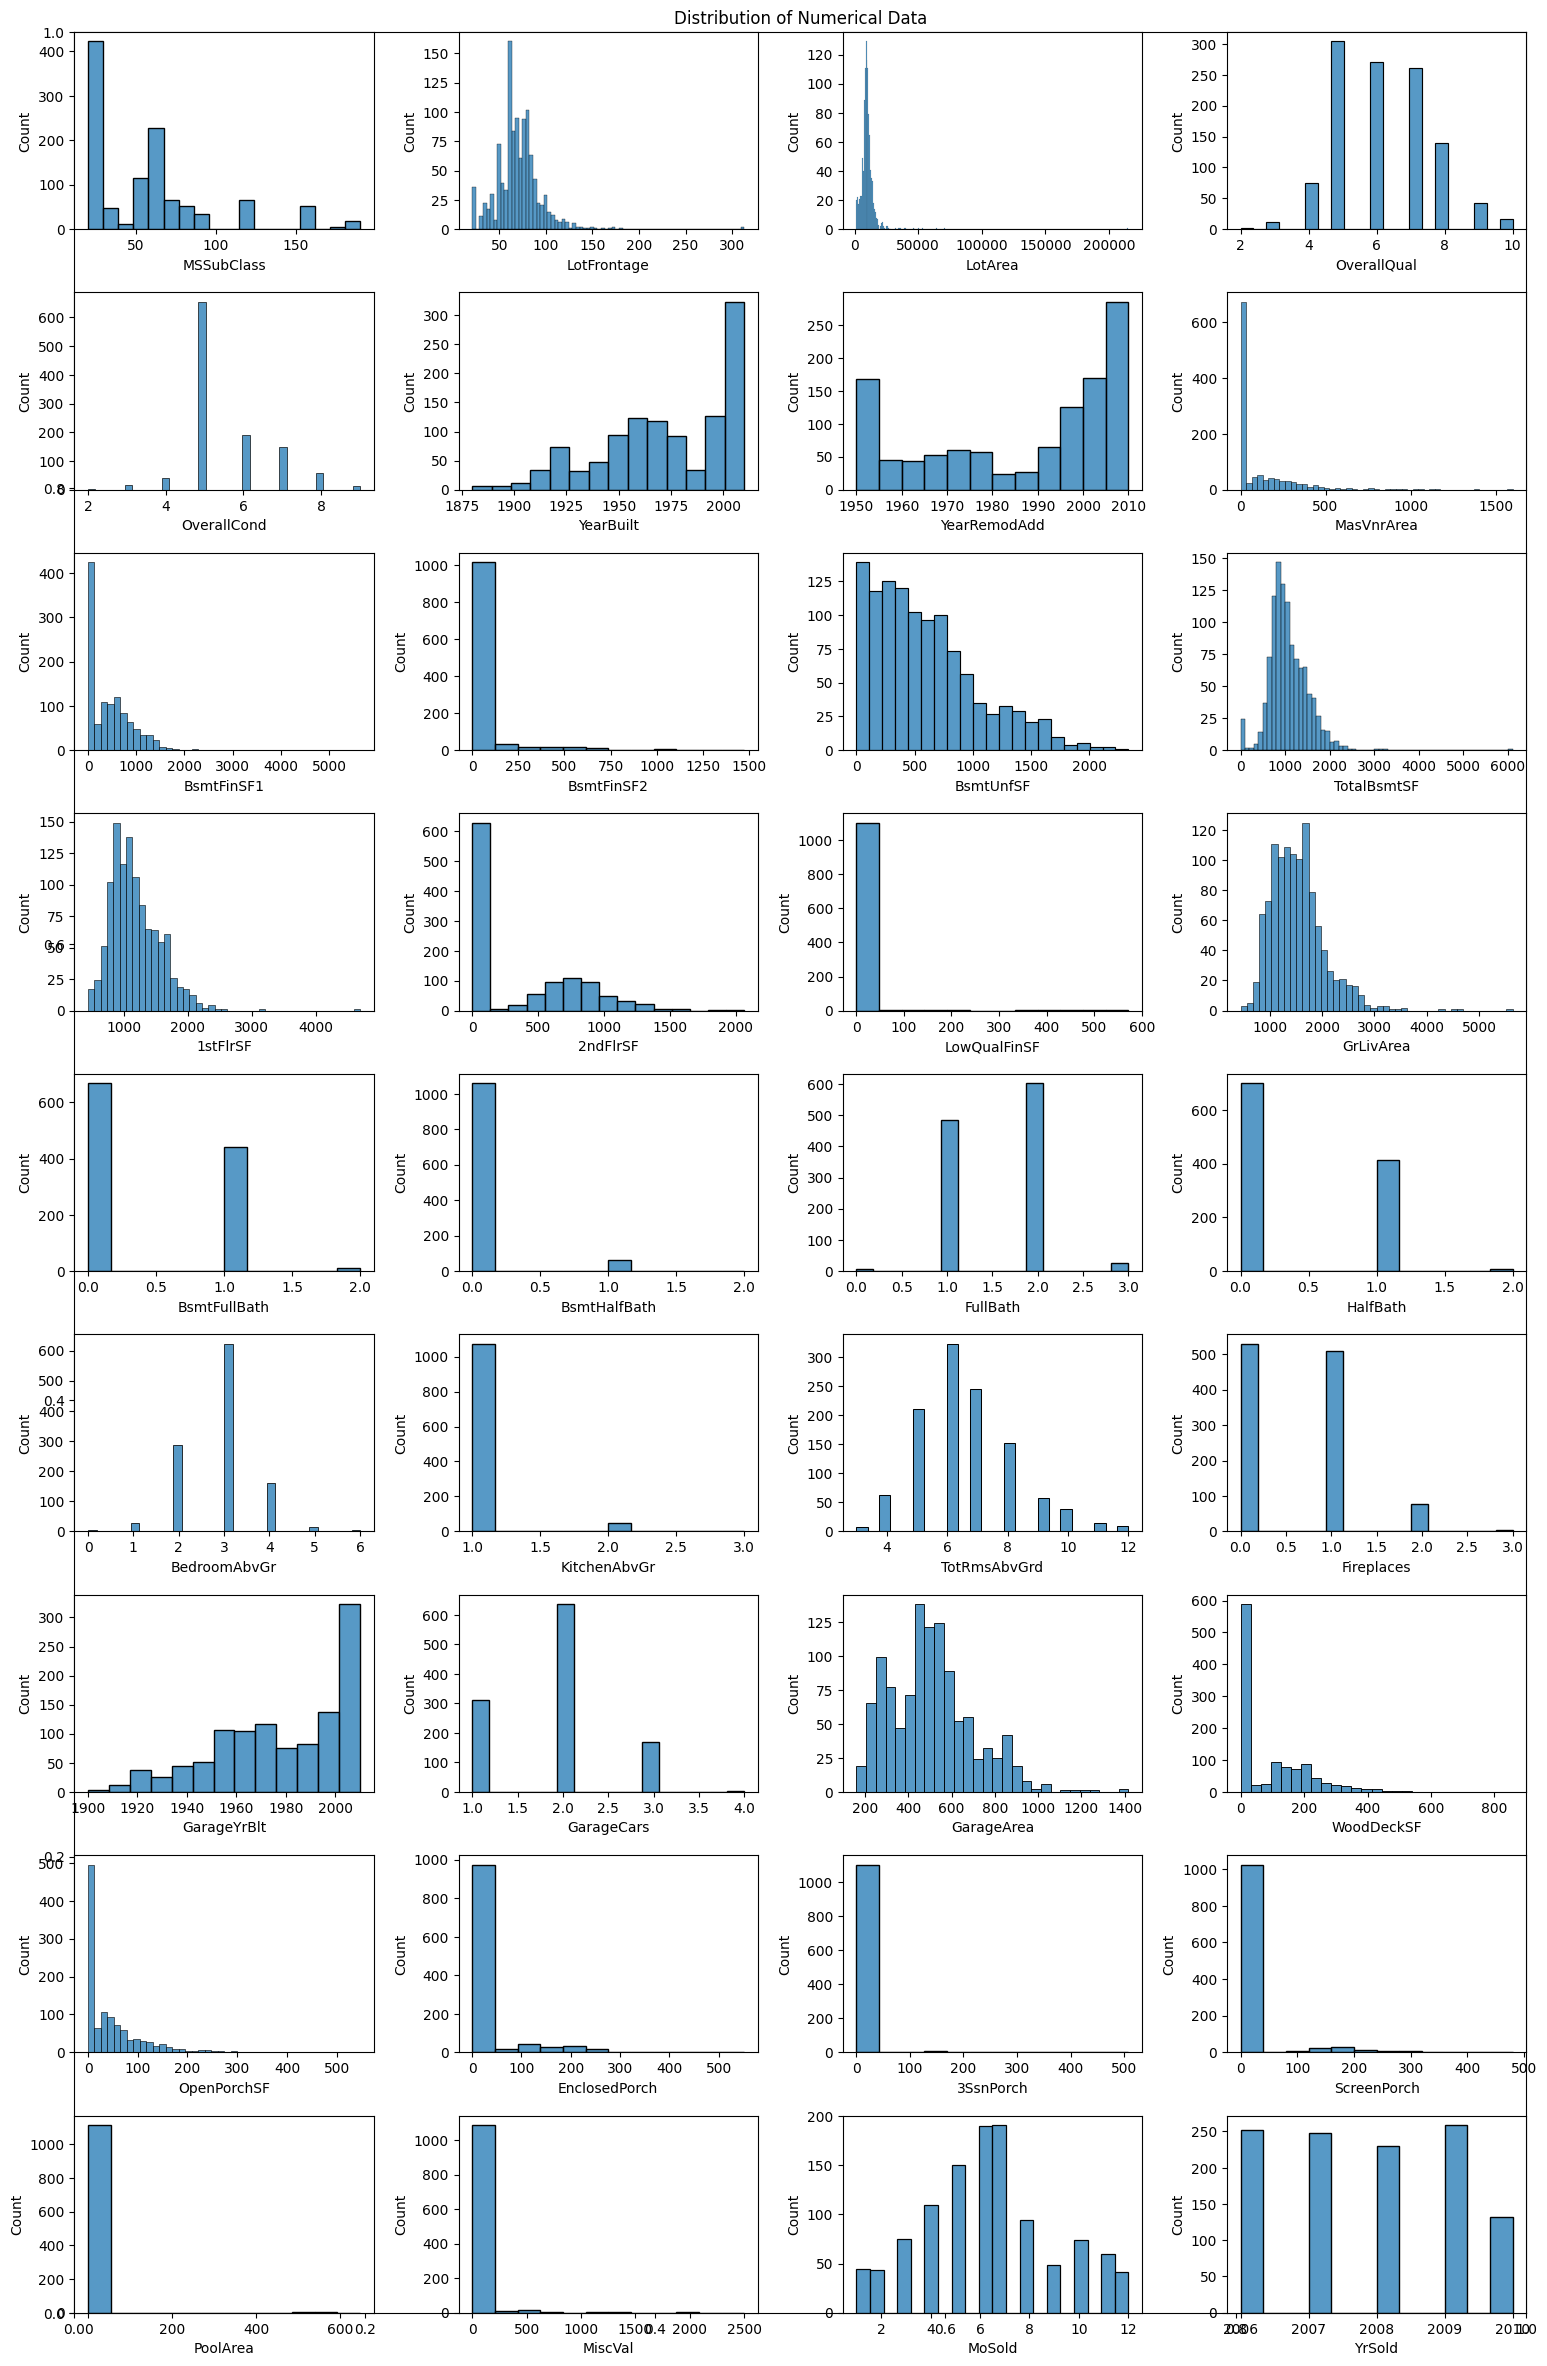

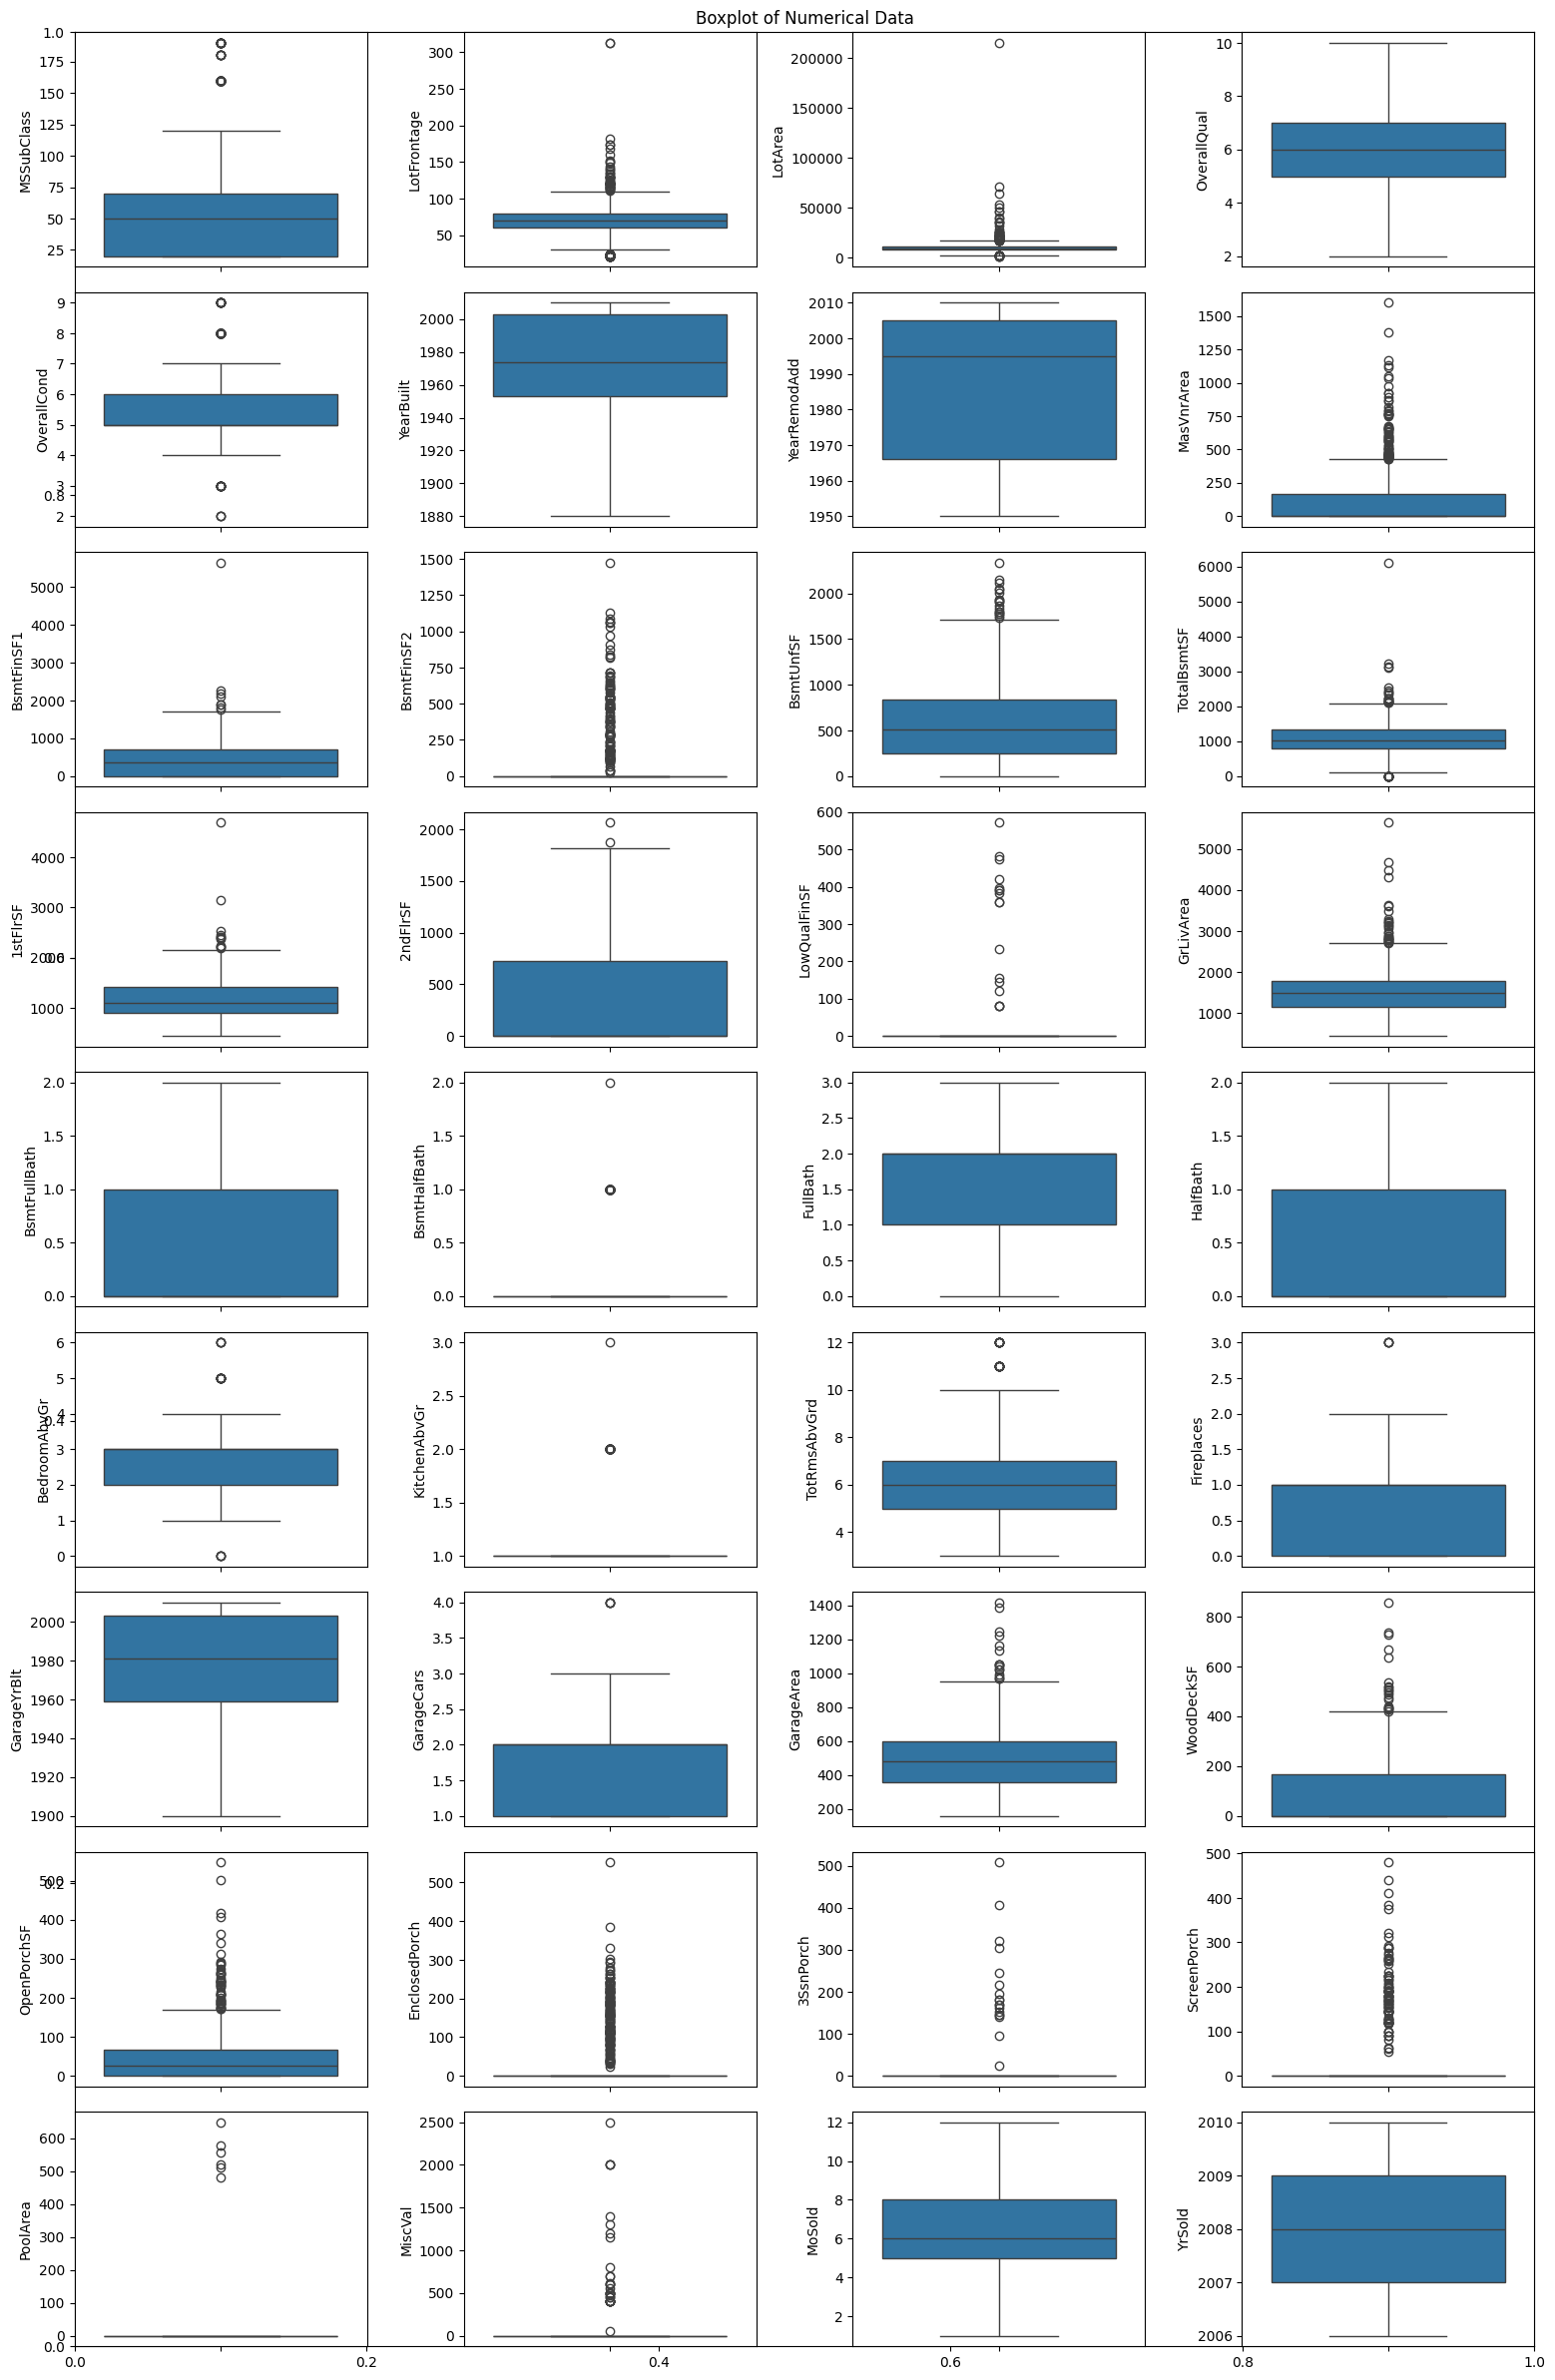

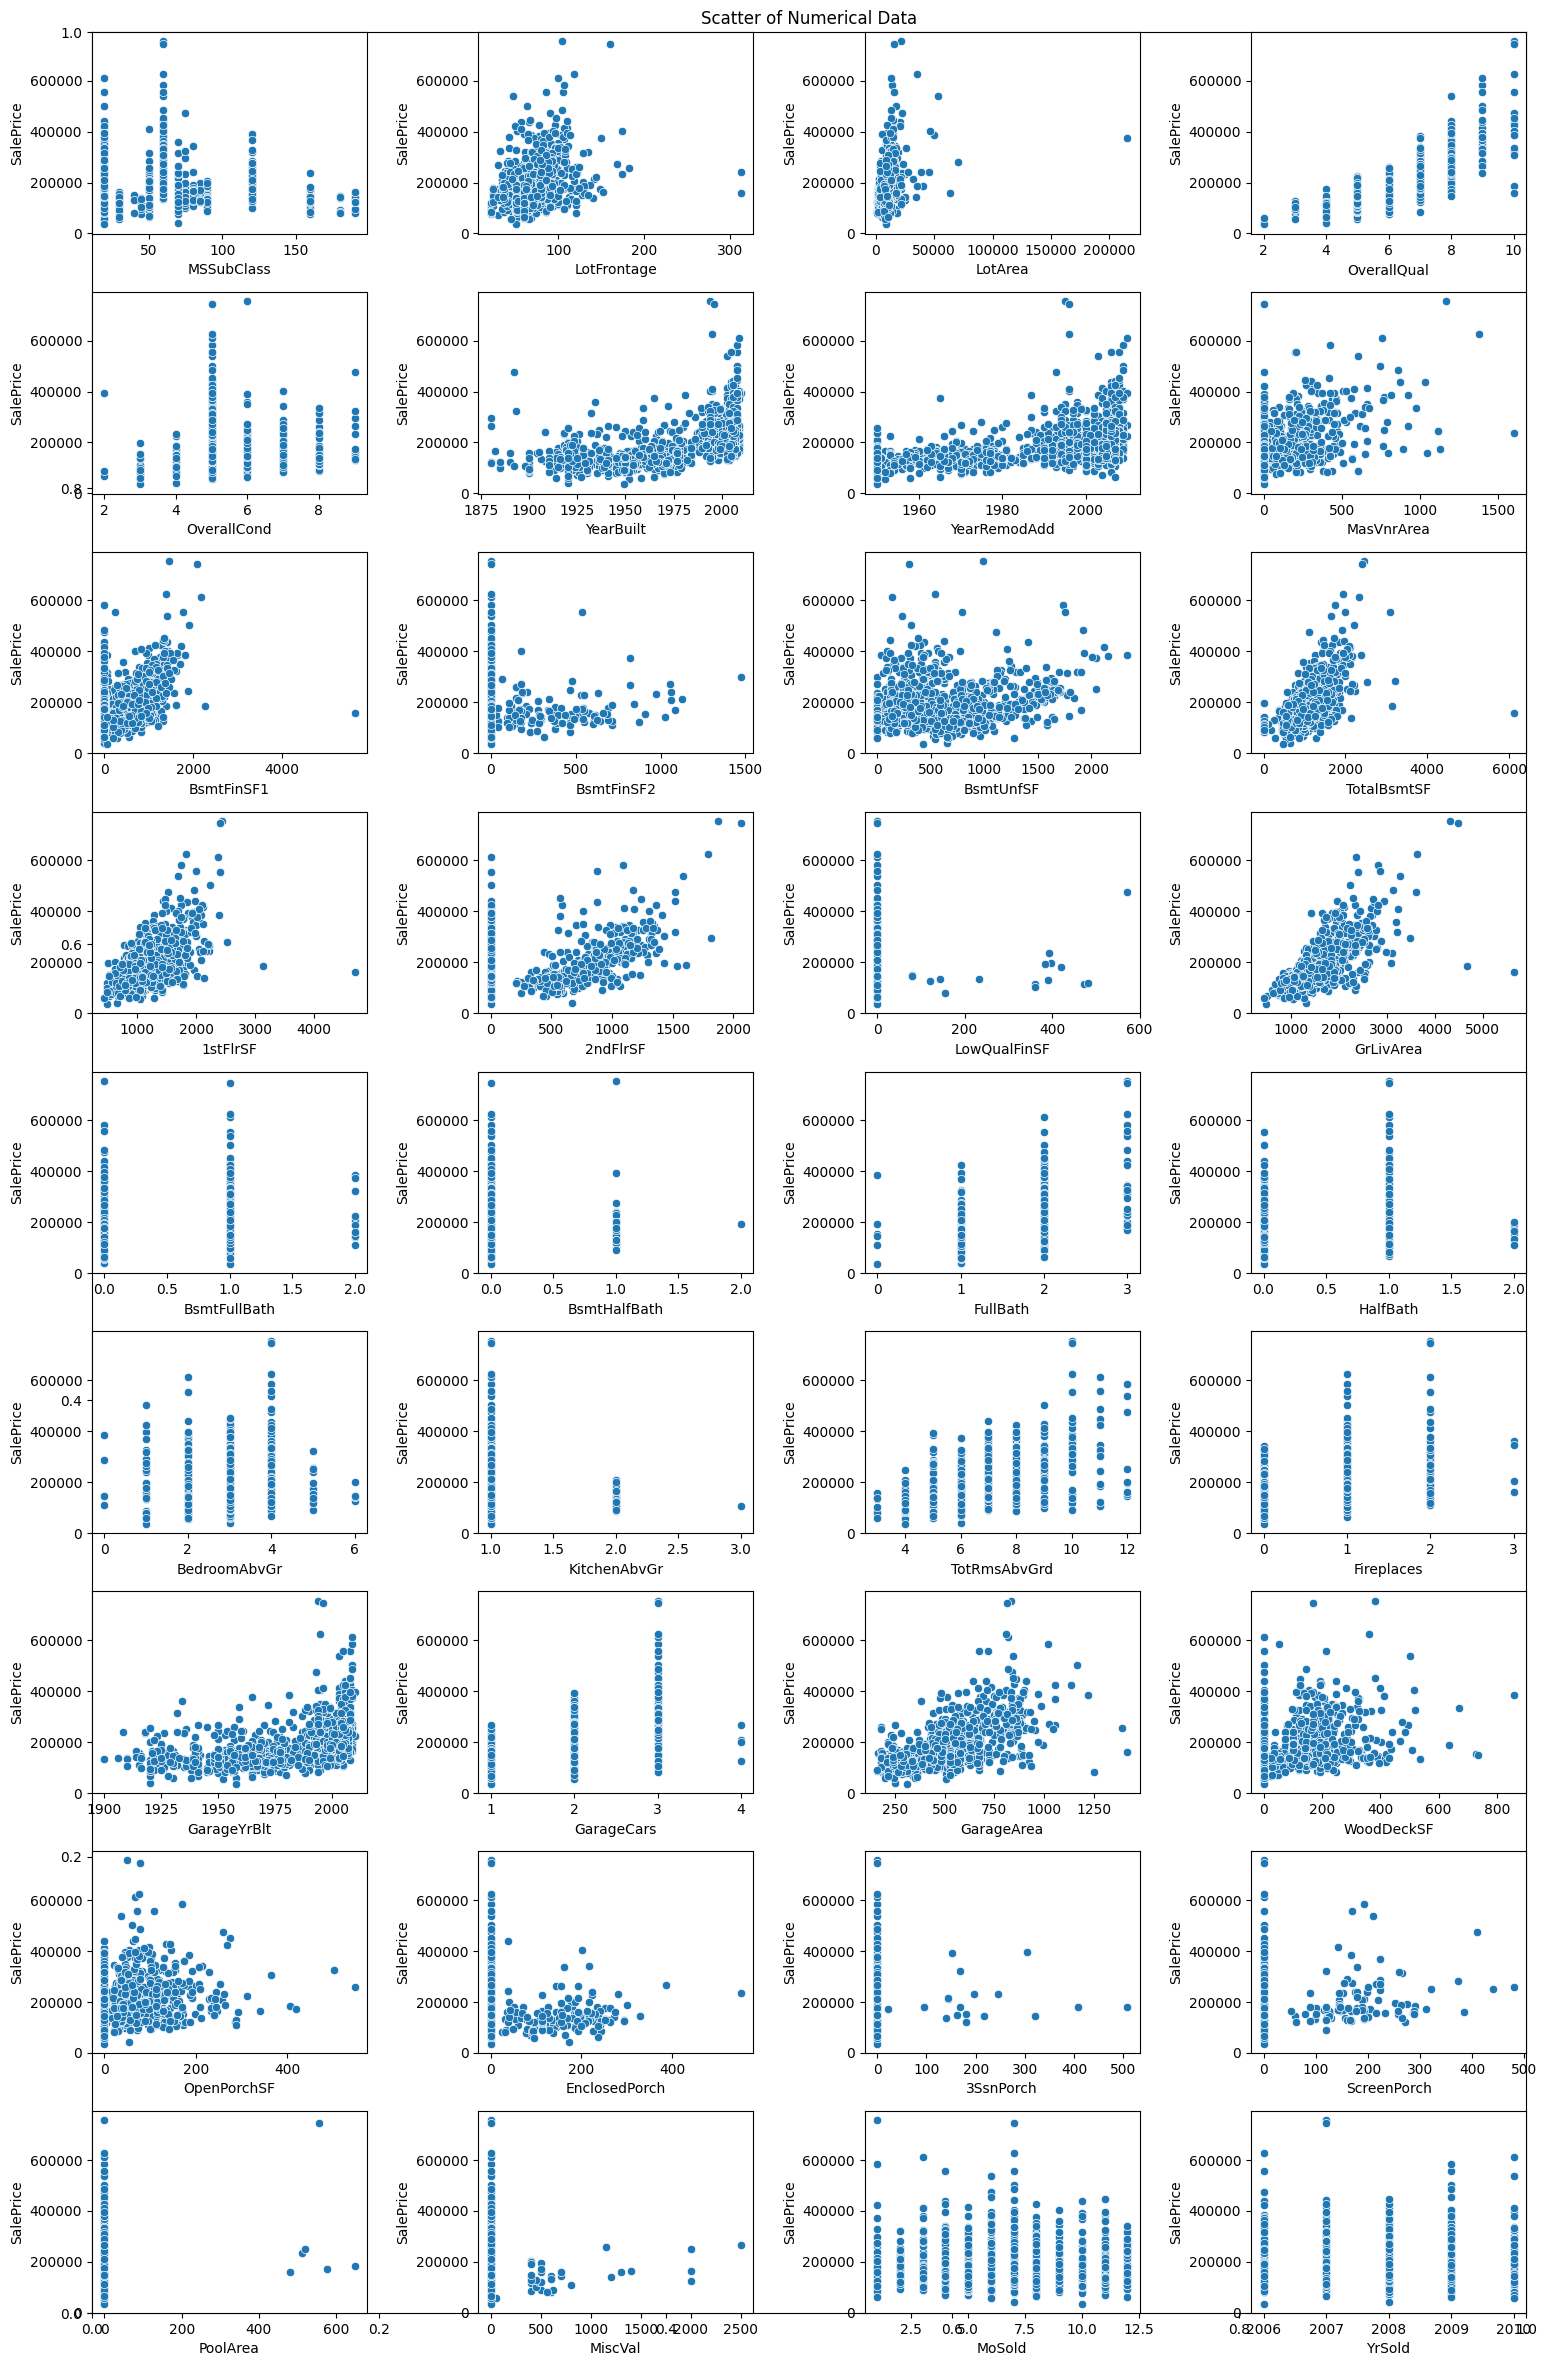

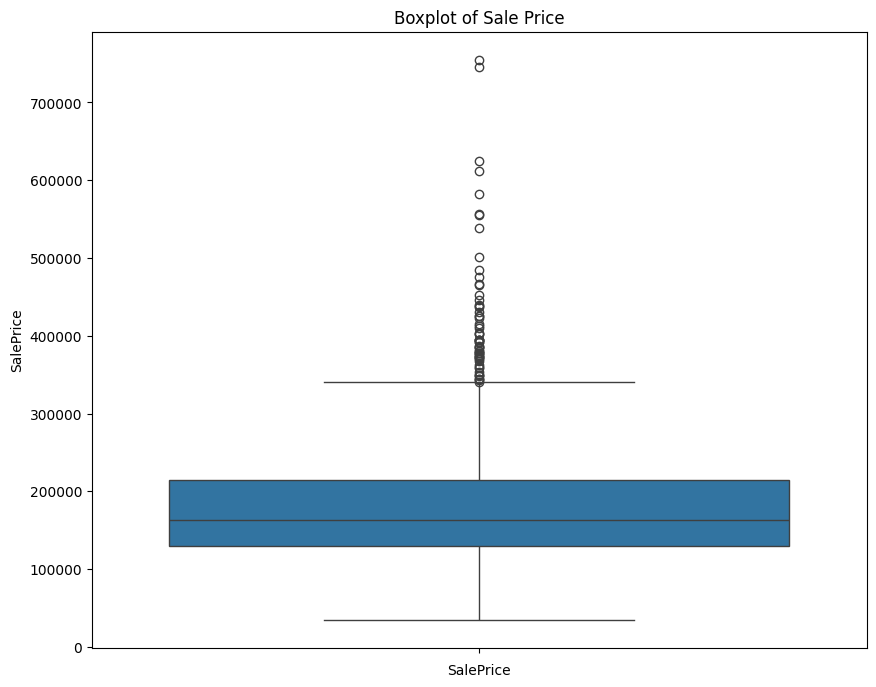

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", "use_inf_as_na")

trainFilepath = "Data/train.csv"
trainData = pd.read_csv(trainFilepath)

num_attributes = trainData.select_dtypes(exclude="object").drop("SalePrice", axis=1).copy()
num_attributes.drop("Id", axis=1, inplace=True)
num_attributes = num_attributes.dropna(axis=0)

fig = plt.figure(figsize=(16,24))
plt.title("Distribution of Numerical Data")
for i, col in enumerate(num_attributes.columns):
    fig.add_subplot(9, 4, i+1)
    sns.histplot(num_attributes[col])
    plt.xlabel(col)

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(16,24))
plt.title("Boxplot of Numerical Data")
for i in range(len(num_attributes.columns)):
    fig.add_subplot(9,4,i+1)
    sns.boxplot(y=num_attributes.iloc[:, i])

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(16,24))
plt.title("Scatter of Numerical Data")
for i in range(len(num_attributes.columns)):
    fig.add_subplot(9,4,i+1)
    sns.scatterplot(x=num_attributes.iloc[:, i], y=trainData.SalePrice)
    plt.xlabel(num_attributes.columns[i])

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10,8))
plt.title("Boxplot of Sale Price")
sns.boxplot(y=trainData.SalePrice)
plt.xlabel("SalePrice")
plt.show()

# **EDA for categorical values:**

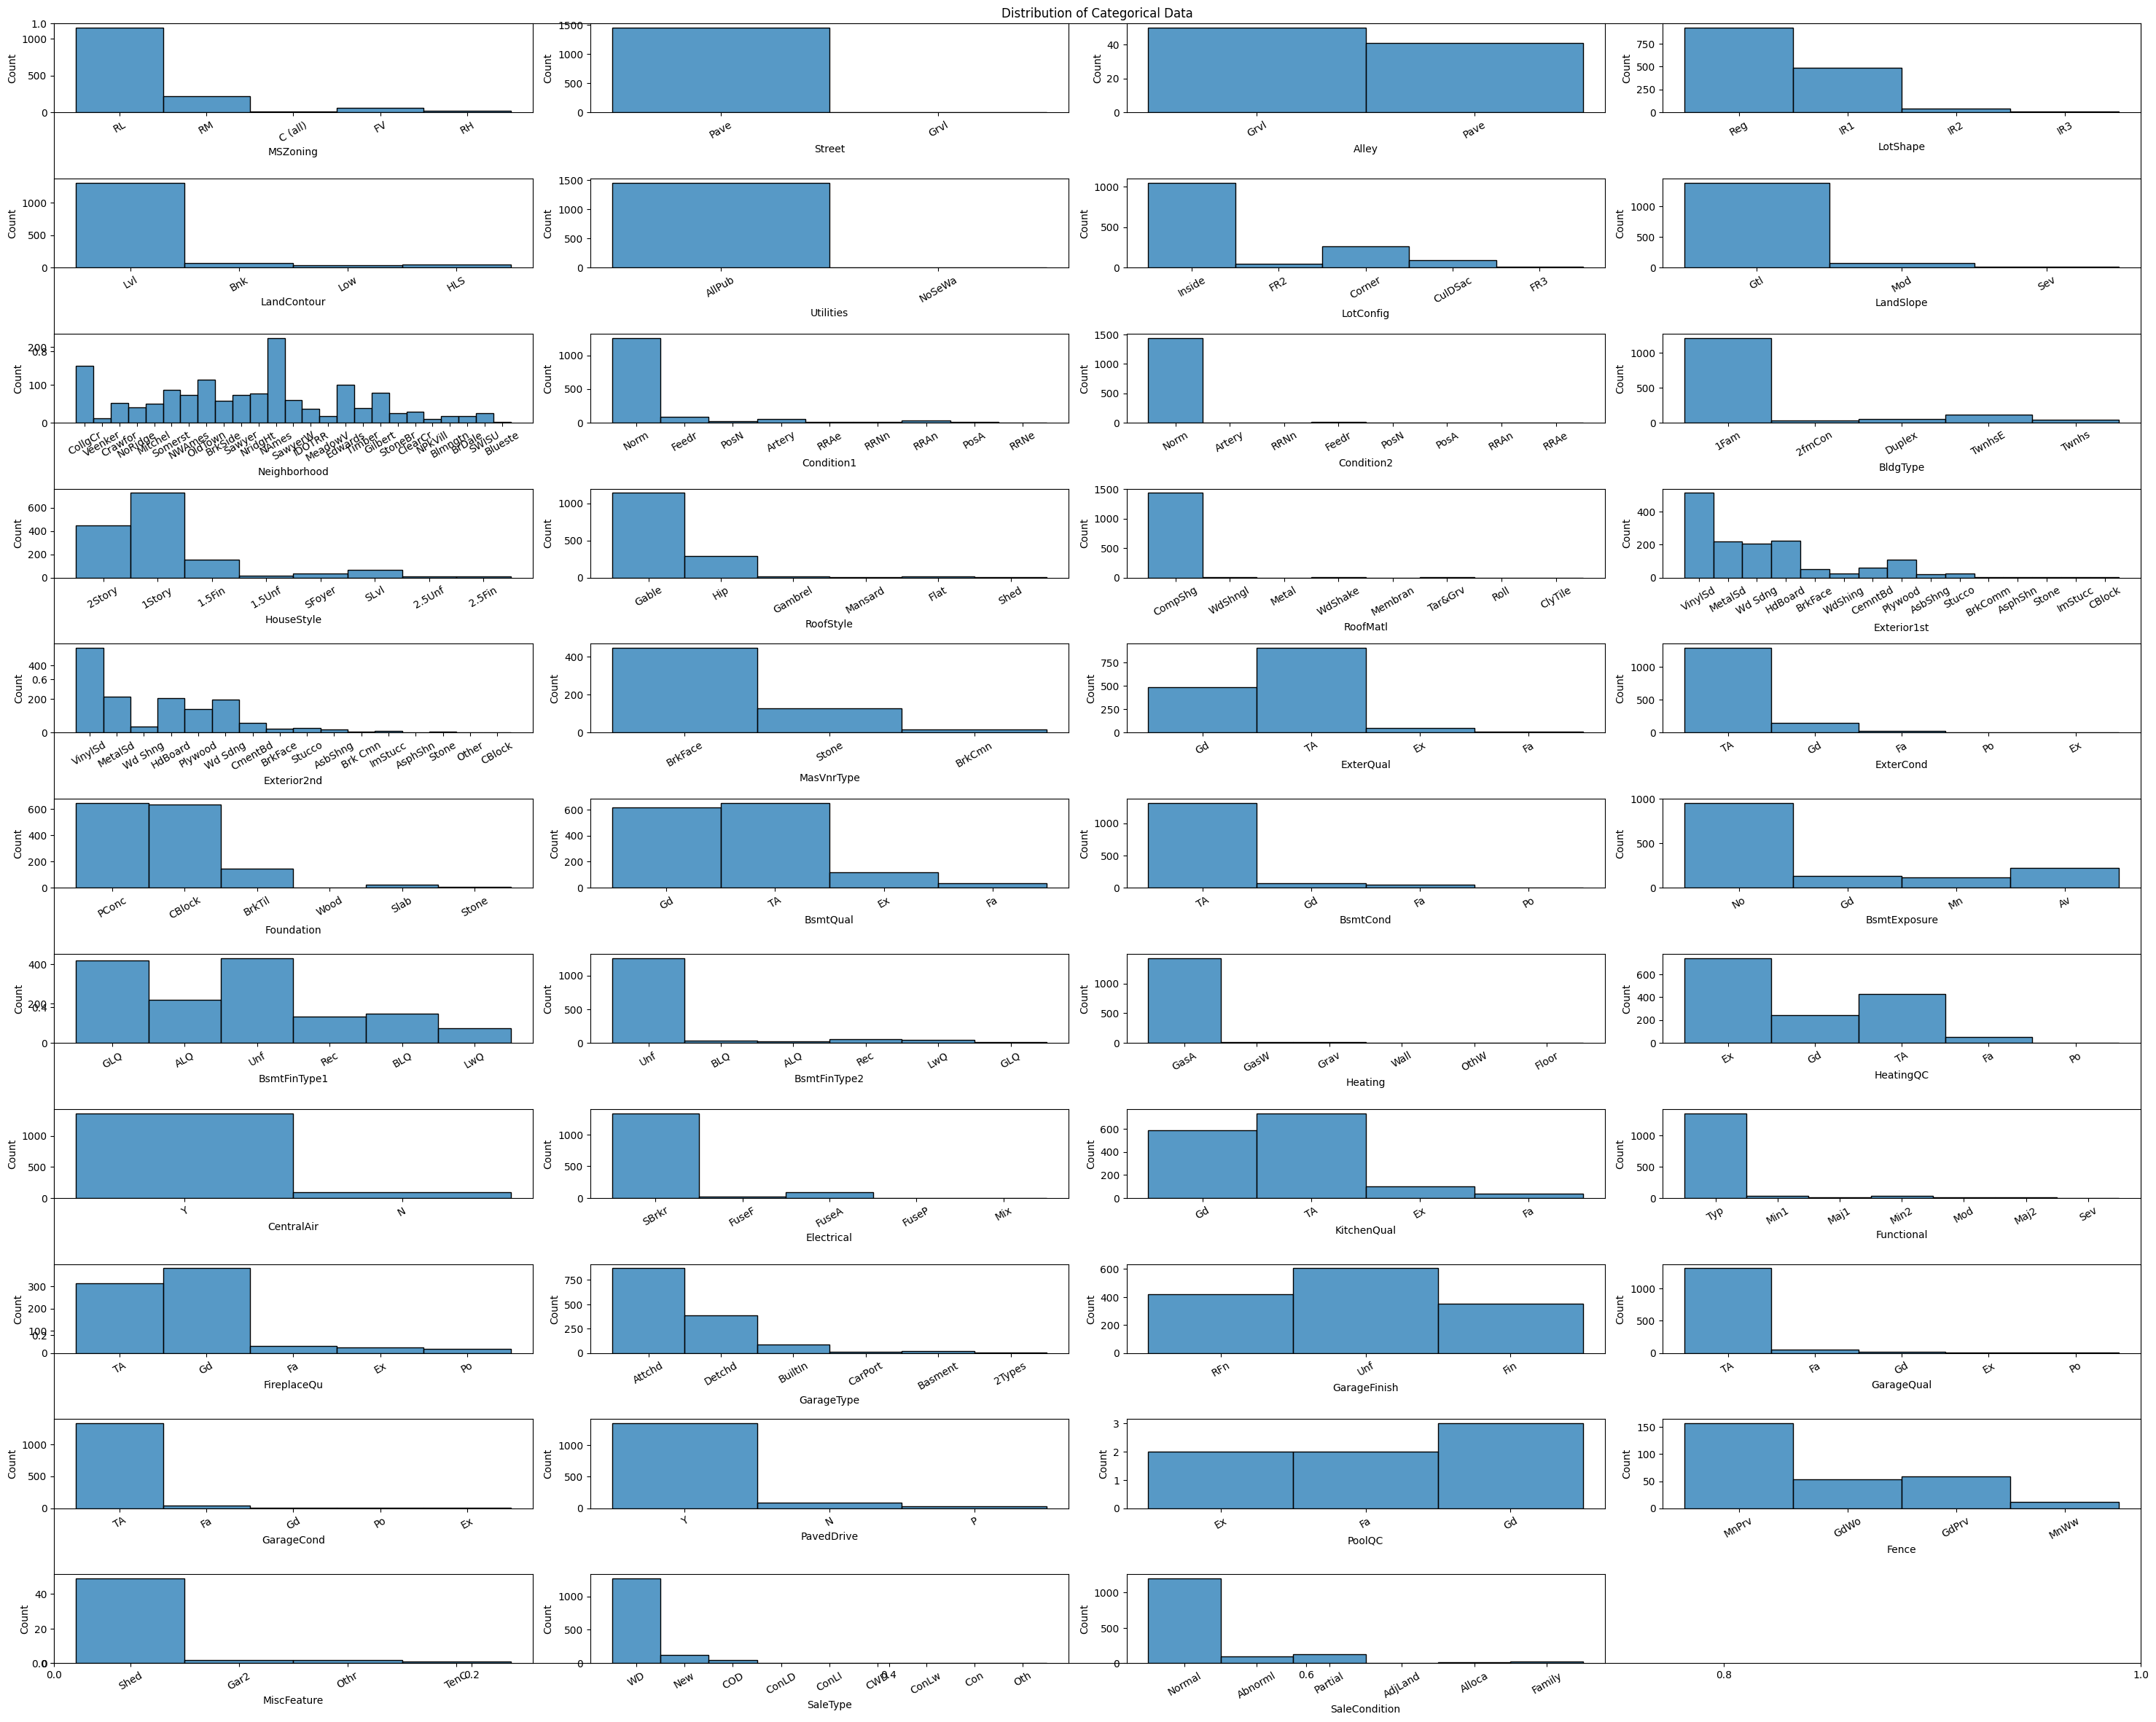

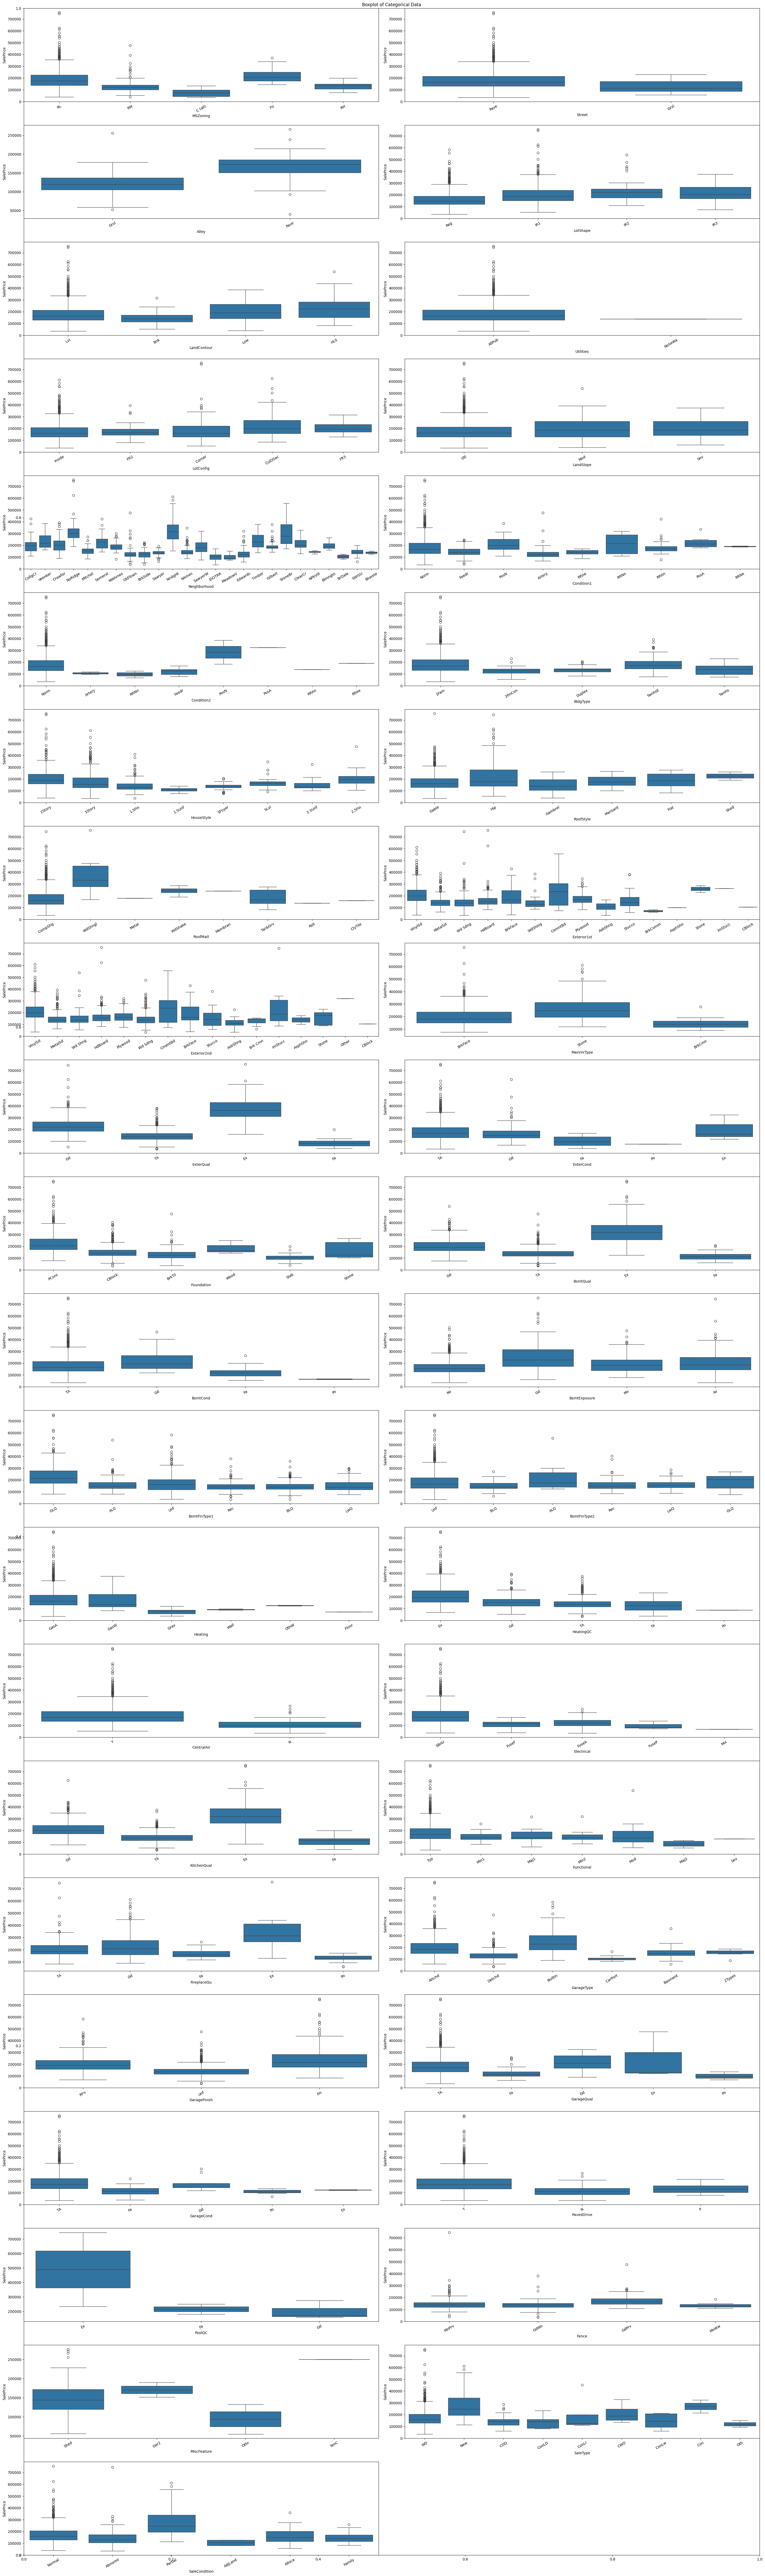

In [3]:
cat_attributes = trainData.select_dtypes(include="object").copy()

fig = plt.figure(figsize=(30,24))
plt.title("Distribution of Categorical Data")
for i, col in enumerate(cat_attributes.columns):
    fig.add_subplot(11, 4, i+1)
    sns.histplot(cat_attributes[col])
    plt.xlabel(col)
    plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(30,100))
plt.title("Boxplot of Categorical Data")
for i in range(len(cat_attributes.columns)):
    fig.add_subplot(22,2,i+1)
    sns.boxplot(x=cat_attributes.iloc[:, i], y=trainData.SalePrice)
    plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

# **Selecting features and creating test and train data:**

In [4]:
from sklearn.model_selection import train_test_split

y = trainData.SalePrice

featuresToDrop= ["MSSubClass", "MasVnrArea", "BsmtFinSF2", "LowQualFinSF", "KitchenAbvGr", "BedroomAbvGr", "GarageCars",
                 "MiscVal", "MoSold", "YrSold", "Street", "Alley", "Utilities", "Condition2", "RoofMatl", "BsmtFinType2", "SalePrice", "Id"]
X = trainData.drop(featuresToDrop, axis=1)

X.YearRemodAdd = 2025 - X.YearRemodAdd
X.rename(columns={"YearRemodAdd": "RemodAge"}, inplace=True)

X.YearBuilt = 2025 - X.YearBuilt
X.rename(columns={"YearBuilt": "Age"}, inplace=True)

X.loc[X["RemodAge"] == X["Age"], "RemodAge"] = 0

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=1)

X.head()

,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,65.0,8450,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,...,61,0,0,0,0,NaN,NaN,NaN,WD,Normal
1,RL,80.0,9600,Reg,Lvl,FR2,Gtl,Veenker,Feedr,1Fam,...,0,0,0,0,0,NaN,NaN,NaN,WD,Normal
2,RL,68.0,11250,IR1,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,...,42,0,0,0,0,NaN,NaN,NaN,WD,Normal
3,RL,60.0,9550,IR1,Lvl,Corner,Gtl,Crawfor,Norm,1Fam,...,35,272,0,0,0,NaN,NaN,NaN,WD,Abnorml
4,RL,84.0,14260,IR1,Lvl,FR2,Gtl,NoRidge,Norm,1Fam,...,84,0,0,0,0,NaN,NaN,NaN,WD,Normal


# **Perform ML on training data:**

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, TargetEncoder, StandardScaler

ordinalFeatures =  ["LotShape", "LandSlope", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC", "PavedDrive", "CentralAir", "BsmtExposure", "Fence", "GarageFinish", "Functional"]
ohFeatures = ["MSZoning", "LotConfig", "BldgType", "HouseStyle", "RoofStyle", "Foundation", "Condition1", "MiscFeature", "Heating", "Electrical", "GarageType", "LandContour", "Exterior1st", "Exterior2nd", "MasVnrType", "SaleType", "SaleCondition", "BsmtFinType1"]
targetFeatures = ["Neighborhood"]

numData = X.select_dtypes(exclude="object").columns

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer()),
    ('scaler', StandardScaler())
])

categorical_ordinal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer()),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

categorical_oh_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer()),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

categorical_target_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer()),
    ("target", TargetEncoder(smooth="auto"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numData),
        ("cat_ord", categorical_ordinal_transformer, ordinalFeatures),
        ("cat_oh", categorical_oh_transformer, ohFeatures),
        ("cat_tgt", categorical_target_transformer, targetFeatures)
    ])

param_grid = {
    "model__n_estimators": [500,1000,1500],
    "model__max_depth": [20,30,40],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 5],
    "preprocessor__num__imputer__strategy": ["constant"],
    "preprocessor__cat_ord__imputer__strategy": ["most_frequent"],
    "preprocessor__cat_oh__imputer__strategy": ["most_frequent"],
    "preprocessor__cat_tgt__imputer__strategy": ["most_frequent"]
}

model = RandomForestRegressor(random_state=0, criterion="absolute_error")

pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", model)
                          ])

cv_strategy = KFold(n_splits=3, shuffle=True, random_state=1)

grid_search = GridSearchCV(pipeline, param_grid, cv=cv_strategy, scoring="neg_mean_absolute_error", n_jobs=3)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

predictions = grid_search.predict(X_valid)

score = mean_absolute_error(y_valid, predictions)
print("MAE:", score) # Lowest: 16091.9

c:\Users\jason\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters found:  {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 500, 'preprocessor__cat_oh__imputer__strategy': 'most_frequent', 'preprocessor__cat_ord__imputer__strategy': 'most_frequent', 'preprocessor__cat_tgt__imputer__strategy': 'most_frequent', 'preprocessor__num__imputer__strategy': 'constant'}
MAE: 16442.489032876714


# **Run prediction on all data**

In [ ]:
testFilepath = "Data/test.csv"
testData = pd.read_csv(testFilepath)

X_test = testData.drop(featuresToDrop, axis=1, errors="ignore")

X_test.YearRemodAdd = 2025 - X_test.YearRemodAdd
X_test.rename(columns={"YearRemodAdd": "RemodAge"}, inplace=True)

X_test.YearBuilt = 2025 - X_test.YearBuilt
X_test.rename(columns={"YearBuilt": "Age"}, inplace=True)

X_test.loc[X_test["RemodAge"] == X_test["Age"], "RemodAge"] = 0

print(X_test.select_dtypes(exclude="object").columns)
print(X_test.select_dtypes(include="object").columns)

testPredictions = grid_search.predict(X_test)

output = pd.DataFrame({"Id": testData.Id, "SalePrice": testPredictions})
output.to_csv("Data/submission.csv", index=False)

print("Output saved")